# code for predicting the phonon cutoff frequency of materials


# Import pkgs And Utils

In [1]:
# import pkgs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import plotly.express as px
import random
import pickle

# AutoML
from flaml import AutoML
# kflod
from sklearn.model_selection import KFold

In [10]:
# UtilTools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Evaluate the predicted results
def regression_metrics(true,pred):
    print('MSE:', mean_squared_error(true, pred))
    print('RMSE:',np.sqrt(mean_squared_error(true,pred)))  
    print('MAE:',mean_absolute_error(true,pred))
    print('R2: ',r2_score(true, pred))
    
    result_dict = {
    'model_name': automl.best_estimator,
    'r2': r2_score(true, pred),
    'mae': mean_absolute_error(true,pred),
    'rmse':np.sqrt(mean_squared_error(true,pred))
    }
    return result_dict

In [11]:
# StandardScaler
from sklearn.preprocessing import StandardScaler

def dataStandardScaler(X):
    std_scale = StandardScaler().fit(X) 
    X_std = std_scale.transform(X)     
    X_std = pd.DataFrame(X_std,
                         columns=X.columns,
                         index=X.index)
    return X_std

In [12]:
# R2 figure 
from sklearn.metrics import r2_score
def plot_pred_act(act, pred, model, reg_line=True, label=''):
    xy_max = np.max([np.max(act), np.max(pred)])

    # set font as Times New Roman
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.weight'] = 'bold'
    plt.rcParams.update({'font.size':20})
    
    plot = plt.figure(figsize=(16,10))
    plt.plot(act, pred, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
    plt.plot([10, xy_max], [10, xy_max], 'k--', label='ideal')  
    # fit lines
    if reg_line:
        polyfit = np.polyfit(act, pred, deg=1)
        reg_ys = np.poly1d(polyfit)(np.unique(act))
        plt.plot(np.unique(act), reg_ys, alpha=1, label='linear fit') 
    
    plt.axis('scaled') 
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'
    plt.xlabel(f'{label}')  
    plt.ylabel(f'Predicted {label}') 
    plt.legend([f'{model}, r2: {r2_score(act, pred):0.4f}'],loc='upper left') 
    
    return plot

In [6]:
# Set Pandas display options
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)

# Show All 
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [13]:
# set font as Times New Roman
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
# set font size as 20
plt.rcParams.update({'font.size':20})

# Import Data

In [5]:
# import train data
path = "Data/phonon data/ABO3_featureEngeer_simplify_symbol.csv"
df_phonon = pd.read_csv(path)
df_phonon.dropna(axis=1,how='all',inplace=True)
df_phonon

,number,material_id,formula,Wmax,nsites,volume,density,spg_num,a,b,...,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_min,TC_max,TC_mean,TC_std
0,1,mp-775761,AgClO3,25.79,20,291.059723,4.366023,198,6.627159,6.627159,...,38.263880,47.583699,0.6,1.60,0.88,0.523723,0.00890,430.0,86.017728,229.832823
1,2,mp-849271,AgIO3,21.92,20,331.979908,5.657596,62,5.915064,6.645817,...,56.554174,66.859027,0.6,1.60,0.96,0.595219,0.02658,430.0,86.105748,229.774116
2,3,mp-8196,AgNO3,42.39,5,66.943057,4.213744,160,4.151836,4.151836,...,33.974620,49.382995,0.6,1.60,0.81,0.528475,0.02583,430.0,86.021114,229.830561
3,4,mp-558637,AgTeO3,20.54,40,574.826171,6.550948,14,11.826693,6.024564,...,56.693280,67.120922,0.6,1.60,0.96,0.595219,0.02658,430.0,86.615948,229.438281
4,5,mp-561489,AgTeO3,21.80,20,274.180033,6.867123,11,5.461746,6.918137,...,56.693280,67.120922,0.6,1.60,0.96,0.595219,0.02658,430.0,86.615948,229.438281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,341,mp-13334,ZnSnO3,20.30,10,117.570079,6.556765,161,5.659122,5.659122,...,46.423440,54.650398,0.6,1.45,0.92,0.525425,0.02658,120.0,37.415948,65.162534
341,342,mp-16819,ZnTeO3,23.07,40,572.633639,5.591035,61,6.329067,7.339284,...,48.201440,58.891988,0.6,1.40,0.91,0.507796,0.02658,120.0,24.615948,63.749727
342,343,mp-647557,ZrPbO3,23.09,40,605.836514,7.596077,32,6.042341,8.386099,...,69.284440,100.035587,0.6,1.80,1.03,0.711638,0.02658,35.0,11.615948,19.633707
343,344,mp-755798,ZrPbO3,22.85,20,291.636419,7.889928,62,5.889325,5.927420,...,69.284440,100.035587,0.6,1.80,1.03,0.711638,0.02658,35.0,11.615948,19.633707


In [11]:
# target 
target_phonon = df_phonon.loc[:,'Wmax'] 
target_phonon 

0      25.79
1      21.92
2      42.39
3      20.54
4      21.80
       ...  
340    20.30
341    23.07
342    23.09
343    22.85
344    23.46
Name: Wmax, Length: 345, dtype: float64

In [12]:
# feature set
featureset_phonon = df_phonon.iloc[:,4:]
featureset_phonon.head()

,nsites,volume,density,spg_num,a,b,c,alpha,beta,gamma,...,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_min,TC_max,TC_mean,TC_std
0,20,291.059723,4.366023,198,6.627159,6.627159,6.627159,90.000000,90.000000,90.000000,...,38.263880,47.583699,0.6,1.6,0.88,0.523723,0.00890,430.0,86.017728,229.832823
1,20,331.979908,5.657596,62,5.915064,6.645817,8.445084,90.000000,90.000000,90.000000,...,56.554174,66.859027,0.6,1.6,0.96,0.595219,0.02658,430.0,86.105748,229.774116
2,5,66.943057,4.213744,160,4.151836,4.151836,4.151836,77.224160,77.224158,77.224160,...,33.974620,49.382995,0.6,1.6,0.81,0.528475,0.02583,430.0,86.021114,229.830561
3,40,574.826171,6.550948,14,11.826693,6.024564,9.221229,61.033231,90.000000,90.000000,...,56.693280,67.120922,0.6,1.6,0.96,0.595219,0.02658,430.0,86.615948,229.438281
4,20,274.180033,6.867123,11,5.461746,6.918137,7.399802,90.000001,89.999993,101.302165,...,56.693280,67.120922,0.6,1.6,0.96,0.595219,0.02658,430.0,86.615948,229.438281


In [13]:
# Calculate the variance of the feature set
variance = featureset_phonon.var()
pd.set_option('display.float_format', '{:.4f}'.format)
print(variance)

nsites      236.2669
volume    49517.6714
density       3.4139
spg_num    4739.7340
a             3.1151
             ...    
Ra_std        0.0168
TC_min        0.0000
TC_max     7796.6253
TC_mean     414.2452
TC_std     2185.3329
Length: 100, dtype: float64


In [14]:
# drop deleted feature names
drop_features = variance[variance < 0.001]
print("Feature length with variance less than 0.0001:", len(drop_features.index))
print("Feature names with variance less than 0.0001:", drop_features.index)

# 保留方差大于0.01的特征
Variance_Selected_features = variance[variance >= 0.001]
print("Feature length with variance more than 0.0001:", len(Variance_Selected_features.index))
print("Feature names with variance more than 0.0001:", Variance_Selected_features.index)

Feature length with variance less than 0.0001: 8
Feature names with variance less than 0.0001: Index(['EG_max', 'NsV_max', 'NdV_min', 'NfV_min', 'NsU_min', 'NdU_min',
       'NfU_min', 'TC_min'],
      dtype='object')
Feature length with variance more than 0.0001: 92
Feature names with variance more than 0.0001: Index(['nsites', 'volume', 'density', 'spg_num', 'a', 'b', 'c', 'alpha',
       'beta', 'gamma', 'Ef', 'Eg', 'Num_min', 'Num_max', 'Num_mean',
       'Num_std', 'MenNum_min', 'MenNum_max', 'MenNum_mean', 'MenNum_std',
       'Tm_min', 'Tm_max', 'Tm_mean', 'Tm_std', 'Column_min', 'Column_max',
       'Column_mean', 'Column_std', 'Row_min', 'Row_max', 'Row_mean',
       'Row_std', 'Rc_min', 'Rc_max', 'Rc_mean', 'Rc_std', 'EG_min', 'EG_mean',
       'EG_std', 'NsV_min', 'NsV_mean', 'NsV_std', 'NpV_min', 'NpV_max',
       'NpV_mean', 'NpV_std', 'NdV_max', 'NdV_mean', 'NdV_std', 'NfV_max',
       'NfV_mean', 'NfV_std', 'NV_min', 'NV_max', 'NV_mean', 'NV_std',
       'NsU_max', 'NsU_

# Feature engineering

In [16]:
# copy data
df_copy_1 = df_phonon.copy()
# Feature set after variance filtering
varianceFeatureSet = ['Wmax'] + Variance_Selected_features.index.to_list()
df_features_varianced = df_copy_1.loc[:,varianceFeatureSet]
df_features_varianced

,Wmax,nsites,volume,density,spg_num,a,b,c,alpha,beta,...,AtomM_max,AtomM_mean,AtomM_std,Ra_min,Ra_max,Ra_mean,Ra_std,TC_max,TC_mean,TC_std
0,25.7900,20,291.0597,4.3660,198,6.6272,6.6272,6.6272,90.0000,90.0000,...,107.8682,38.2639,47.5837,0.6000,1.6000,0.8800,0.5237,430.0000,86.0177,229.8328
1,21.9200,20,331.9799,5.6576,62,5.9151,6.6458,8.4451,90.0000,90.0000,...,126.9045,56.5542,66.8590,0.6000,1.6000,0.9600,0.5952,430.0000,86.1057,229.7741
2,42.3900,5,66.9431,4.2137,160,4.1518,4.1518,4.1518,77.2242,77.2242,...,107.8682,33.9746,49.3830,0.6000,1.6000,0.8100,0.5285,430.0000,86.0211,229.8306
3,20.5400,40,574.8262,6.5509,14,11.8267,6.0246,9.2212,61.0332,90.0000,...,127.6000,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,430.0000,86.6159,229.4383
4,21.8000,20,274.1800,6.8671,11,5.4617,6.9181,7.3998,90.0000,90.0000,...,127.6000,56.6933,67.1209,0.6000,1.6000,0.9600,0.5952,430.0000,86.6159,229.4383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,20.3000,10,117.5701,6.5568,161,5.6591,5.6591,5.6591,56.4281,56.4281,...,118.7100,46.4234,54.6504,0.6000,1.4500,0.9200,0.5254,120.0000,37.4159,65.1625
341,23.0700,40,572.6336,5.5910,61,6.3291,7.3393,12.3277,90.0000,90.0000,...,127.6000,48.2014,58.8920,0.6000,1.4000,0.9100,0.5078,120.0000,24.6159,63.7497
342,23.0900,40,605.8365,7.5961,32,6.0423,8.3861,11.9561,90.0000,90.0000,...,207.2000,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,35.0000,11.6159,19.6337
343,22.8500,20,291.6364,7.8899,62,5.8893,5.9274,8.3543,90.0000,90.0000,...,207.2000,69.2844,100.0356,0.6000,1.8000,1.0300,0.7116,35.0000,11.6159,19.6337


<Axes: >

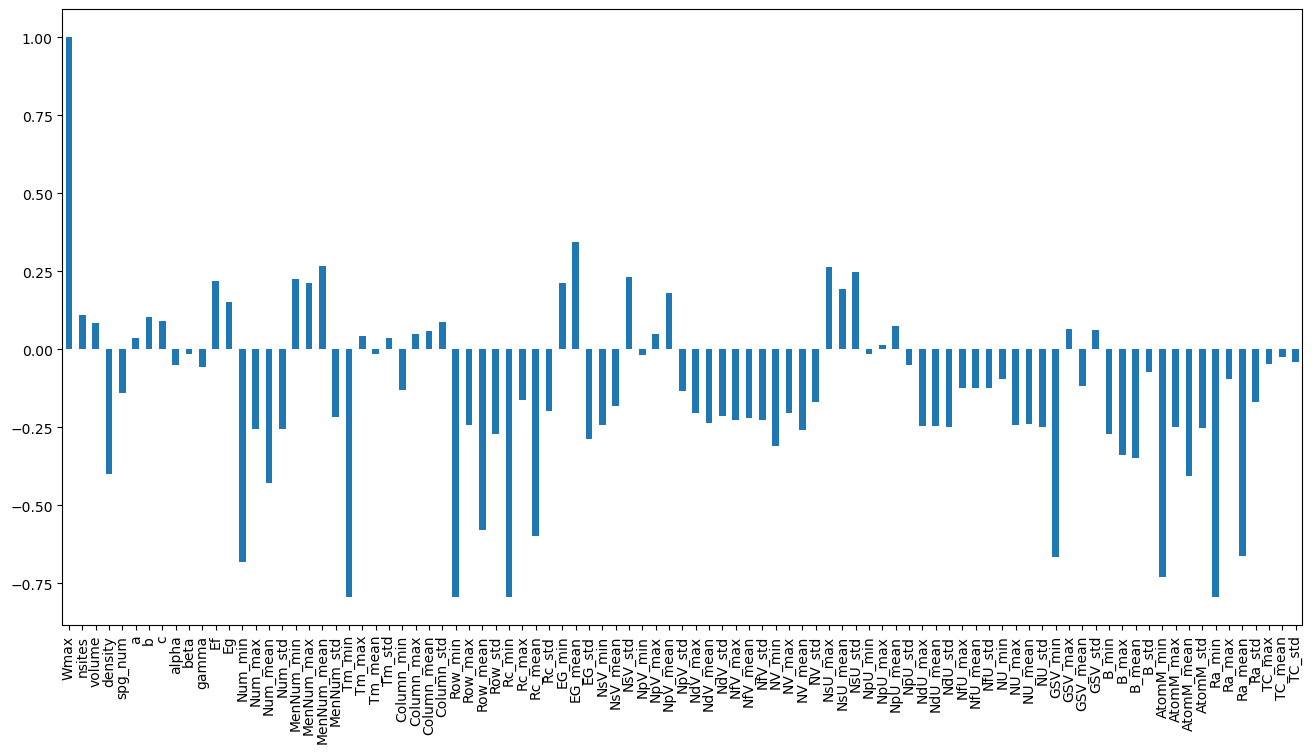

In [17]:
# After variance filtering
df_features_varianced.corr().loc[:, 'Wmax'].plot(kind='bar', figsize=(16, 8))

In [19]:
# drop uncorrelated numeric features (threshold <0.2) 
corr = abs(df_features_varianced.corr().loc['Wmax']) 
corr = corr[corr<0.2] 
cols_to_drop = corr.index.to_list() 
df_features_phonon_select = df_features_varianced.drop(cols_to_drop, axis=1)
print("The correlation coefficient with Wmax is less than 0.2:",cols_to_drop)
print("the length of featureSet after dropping the number of feature sets :",
         len(df_features_phonon_select.columns))

The correlation coefficient with Wmax is less than 0.2: ['nsites', 'volume', 'spg_num', 'a', 'b', 'c', 'alpha', 'beta', 'gamma', 'Eg', 'Tm_max', 'Tm_mean', 'Tm_std', 'Column_min', 'Column_max', 'Column_mean', 'Column_std', 'Rc_max', 'Rc_std', 'NsV_mean', 'NpV_min', 'NpV_max', 'NpV_mean', 'NpV_std', 'NV_std', 'NsU_mean', 'NpU_min', 'NpU_max', 'NpU_mean', 'NpU_std', 'NfU_max', 'NfU_mean', 'NfU_std', 'NU_min', 'GSV_max', 'GSV_mean', 'GSV_std', 'B_std', 'Ra_max', 'Ra_std', 'TC_max', 'TC_mean', 'TC_std']
the length of featureSet after dropping the number of feature sets : 50


In [21]:
# Remove highly correlated features(>0.8)
featureset_phonon = df_features_phonon_select.drop(columns=['Wmax'])

phonon_correlation_matrix = featureset_phonon.corr()

phonon_correlated_features=set()
for i in range(len(phonon_correlation_matrix.columns)):
    for j in range(i):
        if abs(phonon_correlation_matrix.iloc[i,j]) > 0.8:
            colname = phonon_correlation_matrix.columns[i]
            phonon_correlated_features.add(colname)

print("The set of features to remove during filtering:", phonon_correlated_features)
print("The length of features to remove during filtering:", len(phonon_correlated_features))

The set of features to remove during filtering: {'B_mean', 'Row_mean', 'NsV_std', 'AtomM_mean', 'NdU_mean', 'NfV_std', 'Ra_min', 'AtomM_max', 'NsU_std', 'EG_min', 'NU_std', 'Num_max', 'NdV_std', 'AtomM_std', 'EG_std', 'B_min', 'NdU_std', 'MenNum_std', 'NsU_max', 'Num_mean', 'Row_min', 'NU_mean', 'Row_std', 'Ra_mean', 'NdV_mean', 'NfV_mean', 'EG_mean', 'Num_std', 'NV_mean', 'Row_max', 'NfV_max', 'AtomM_min', 'MenNum_mean', 'Rc_min'}
The length of features to remove during filtering: 34


In [23]:
# after dropping
phonon_featureSelected = featureset_phonon.drop(labels=phonon_correlated_features,axis=1)
phonon_featureSelected.head()

,density,Ef,Num_min,MenNum_min,MenNum_max,Tm_min,Rc_mean,NsV_min,NdV_max,NV_min,NV_max,NdU_max,NU_max,GSV_min,B_max
0,4.3660,-0.4168,8,65,94,54.8000,89.0000,1,10,6,11,0,2,9.1050,3
1,5.6576,-0.6986,8,65,96,54.8000,96.4000,1,10,6,17,0,2,9.1050,3
2,4.2137,-0.6527,7,65,87,54.8000,82.8000,1,10,5,11,0,3,9.1050,3
3,6.5509,-1.1288,8,65,90,54.8000,96.2000,1,10,6,16,0,2,9.1050,3
4,6.8671,-1.1291,8,65,90,54.8000,96.2000,1,10,6,16,0,2,9.1050,3


In [24]:
# Feature Sets after filtering
print("The set of features to remove after filtering:",phonon_featureSelected.columns)
print("The length of features to remove after filtering:",len(phonon_featureSelected.columns))


The set of features to remove after filtering: Index(['density', 'Ef', 'Num_min', 'MenNum_min', 'MenNum_max', 'Tm_min',
       'Rc_mean', 'NsV_min', 'NdV_max', 'NV_min', 'NV_max', 'NdU_max',
       'NU_max', 'GSV_min', 'B_max'],
      dtype='object')
The length of features to remove after filtering: 15


In [26]:
# save 
colName = ['number','material_id','formula','Wmax',]+phonon_featureSelected.columns.to_list()

df_save_phonon = df_phonon.loc[:,colName]
df_save_phonon

,number,material_id,formula,Wmax,density,Ef,Num_min,MenNum_min,MenNum_max,Tm_min,Rc_mean,NsV_min,NdV_max,NV_min,NV_max,NdU_max,NU_max,GSV_min,B_max
0,1,mp-775761,AgClO3,25.7900,4.3660,-0.4168,8,65,94,54.8000,89.0000,1,10,6,11,0,2,9.1050,3
1,2,mp-849271,AgIO3,21.9200,5.6576,-0.6986,8,65,96,54.8000,96.4000,1,10,6,17,0,2,9.1050,3
2,3,mp-8196,AgNO3,42.3900,4.2137,-0.6527,7,65,87,54.8000,82.8000,1,10,5,11,0,3,9.1050,3
3,4,mp-558637,AgTeO3,20.5400,6.5509,-1.1288,8,65,90,54.8000,96.2000,1,10,6,16,0,2,9.1050,3
4,5,mp-561489,AgTeO3,21.8000,6.8671,-1.1291,8,65,90,54.8000,96.2000,1,10,6,16,0,2,9.1050,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,341,mp-13334,ZnSnO3,20.3000,6.5568,-1.9402,8,69,87,54.8000,91.8000,2,10,6,14,0,4,9.1050,3
341,342,mp-16819,ZnTeO3,23.0700,5.5910,-1.6334,8,69,90,54.8000,91.6000,2,10,6,16,0,2,9.1050,3
342,343,mp-647557,ZrPbO3,23.0900,7.5961,-2.8465,8,44,87,54.8000,103.8000,2,10,4,28,8,8,9.1050,3
343,344,mp-755798,ZrPbO3,22.8500,7.8899,-2.8420,8,44,87,54.8000,103.8000,2,10,4,28,8,8,9.1050,3


In [27]:
# save to csv
df_save_phonon.to_csv('Data/phonon data/trainData_features15')

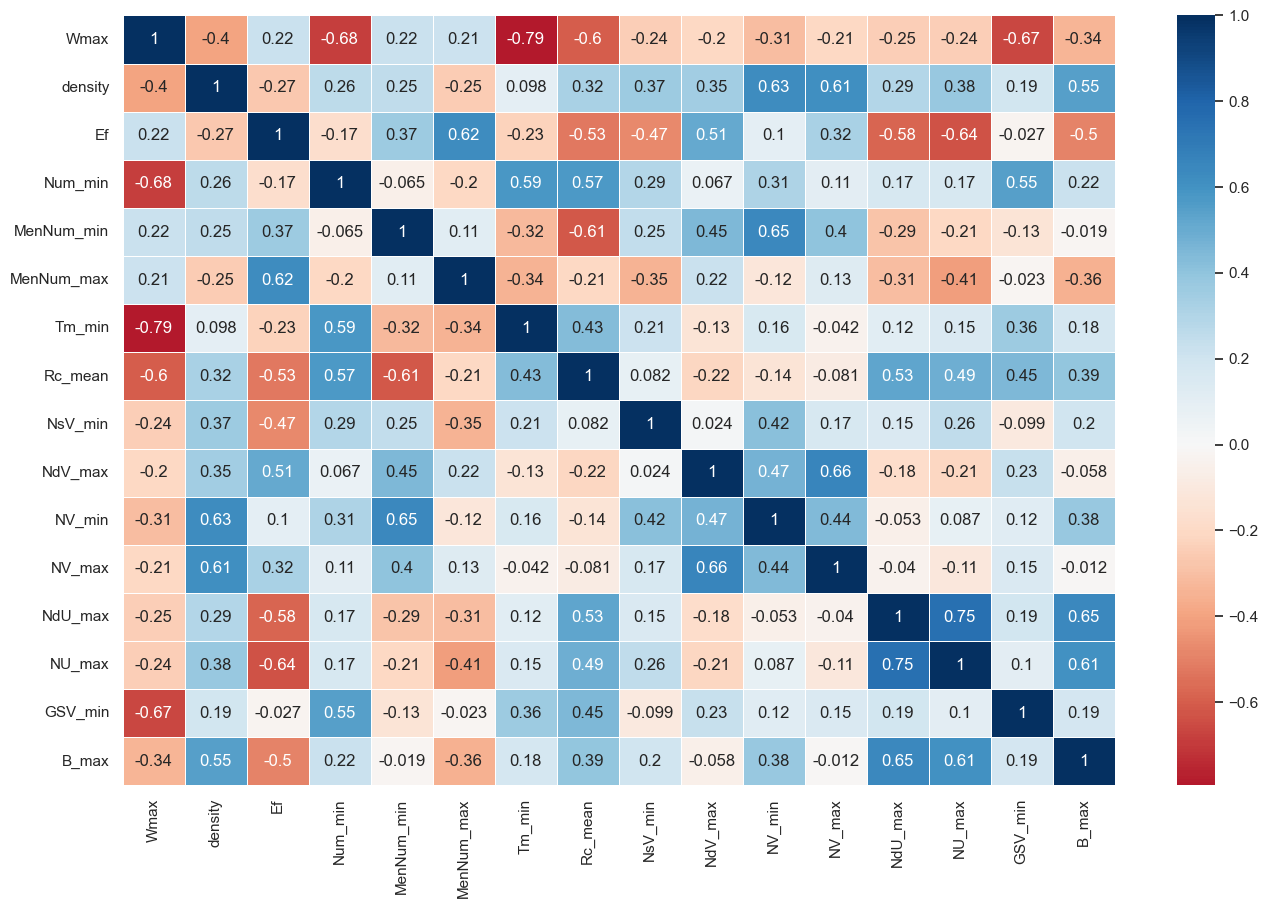

In [42]:
# heatmap
SS = list(phonon_featureSelected.columns)
SS.insert(0,"Wmax")
df_corr = df_features_varianced[SS]

# or read from file
# df_ = pd.read_csv('Data/phonon data/trainData_features15.csv')
# df_corr = df_.iloc[:,3:]

# show heatmap
sns.set(rc={'figure.figsize':(16,10)}) 
sns.heatmap(df_corr.corr(), 
            annot=True, 
            linewidths=.5, 
            center=0, 
            cbar=True, 
            cmap="RdBu") 
plt.show()

# model construction

In [43]:
# import train data after filtering 
df_train_selected = pd.read_csv("Data/phonon data/trainData_features15.csv")
feature_train = df_train_selected.iloc[:,4:]
target_train = df_train_selected["Wmax"]

# StandardScaler
feature_std = dataStandardScaler(feature_train)

# data split
x_train, x_test, y_train, y_test = train_test_split(feature_std,
                                                    target_train,
                                                    test_size=0.2,
                                                    random_state=45)

In [44]:
# renumber
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_train

,density,Ef,Num_min,MenNum_min,MenNum_max,Tm_min,Rc_mean,NsV_min,NdV_max,NV_min,NV_max,NdU_max,NU_max,GSV_min,B_max
0,-0.6516,-1.5342,0.4140,-0.5807,-0.3986,0.1439,1.1326,0.6440,-1.0845,-0.0175,-1.0546,1.4727,0.9915,0.3439,0.8067
1,1.1853,-0.2285,0.4140,0.6542,-0.3986,0.1439,0.2878,0.6440,0.9271,0.5310,1.9122,1.2202,0.6839,0.3439,0.8067
2,1.4193,-0.5812,0.4140,0.2425,-0.3986,0.1439,0.1362,0.6440,0.9271,1.6281,-0.1106,-0.8000,-0.2390,0.3439,0.8067
3,0.7608,-0.1571,0.4140,-0.5807,-0.3986,0.1439,0.2229,0.6440,0.9271,-0.0175,2.0471,1.4727,0.9915,0.3439,0.8067
4,-1.8162,1.5074,-0.2265,-0.9175,-0.3986,0.1439,-1.5315,-1.4721,-1.3081,-1.1145,-1.0546,-0.8000,-0.8542,0.3439,-1.2397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,-0.5170,0.6715,-2.7887,-0.9549,-0.3986,0.1439,-0.8818,-1.4721,0.9271,-1.1145,0.1591,-0.8000,-0.8542,0.3439,-1.2397
272,1.2432,-0.2251,0.4140,-0.3188,-0.3986,0.1439,0.8077,-1.4721,0.9271,1.0796,-0.3803,1.4727,4.6829,0.3439,0.8067
273,-0.7413,2.0487,-4.0698,2.2632,3.6590,-6.9488,-2.9827,-1.4721,0.9271,-1.1145,0.4288,-0.8000,-1.1618,-2.5024,-1.2397
274,0.6089,0.4394,0.4140,-0.7304,-0.3986,0.1439,0.3528,0.6440,0.9271,-0.5660,2.0471,-0.8000,-0.8542,0.3439,-1.2397


## model train

In [45]:
# Add a custom GBR model
from flaml.model import SKLearnEstimator
from flaml import tune
from flaml.data import CLASSIFICATION

class MyGradientBoostingRegressor(SKLearnEstimator):
    def __init__(self, task='binary',n_jobs=None, **config):
        '''Constructor
        Args:
            task: A string of the task type, one of
                'binary', 'multi', 'regression'
            config: A dictionary containing the hyperparameter names
                and 'n_jobs' as keys. n_jobs is the number of parallel threads.
        '''
        super().__init__(task,**config)
        '''task=binary or multi for classification task'''
        if task in CLASSIFICATION:
            from sklearn.ensemble import GradientBoostingClassifier
            self.estimator_class = GradientBoostingClassifier
        else:
            from sklearn.ensemble import GradientBoostingRegressor
            self.estimator_class = GradientBoostingRegressor
    @classmethod
    def search_space(cls, data_size, task):
        '''[required method] search space
        Returns:
            A dictionary of the search space. 
            Each key is the name of a hyperparameter, and value is a dict with
                its domain (required) and low_cost_init_value, init_value,
                cat_hp_cost (if applicable).
                e.g.,
                {'domain': tune.randint(lower=1, upper=10), 'init_value': 1}.
        '''
        space = {
            'loss':{'domain':tune.choice(['squared_error', 'absolute_error', 'huber', 'quantile'])},
            'max_depth': {'domain': tune.randint(lower=1, upper=50)},
            'n_estimators': {'domain': tune.randint(lower=1, upper=1000), 'low_cost_init_value': 4},
            'subsample':{'domain':tune.loguniform(lower=0.01, upper=1.0)},
            'max_features': {'domain': tune.loguniform(lower=0.1, upper=0.99)},
            'learning_rate': {'domain': tune.loguniform(lower=1 / 1024, upper=1.0)},
            'min_samples_split': {'domain': tune.loguniform(lower=0.1, upper=1.0)},
        }
        return space
automl = AutoML()   
automl.add_learner("gbr", MyGradientBoostingRegressor)

In [46]:
# Automl setting
settings = {
            "time_budget": 240,  
            "metric": 'r2',  # 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
            # "estimator_list": ['xgboost'],
            "estimator_list": ['lgbm'],
            # "estimator_list": ['catboost'],
            # "estimator_list": ['rf'],
            # "estimator_list": ['gbr'],
            "task": 'regression',  
            "eval_method":'cv',
            "n_splits":10,
            # "log_file_name": 'log files/train_date.log', 
            # "seed": 46,    
}

In [47]:
# add 10Kflod 
kFold=KFold(n_splits=10, random_state=56, shuffle=True)
automl.fit(X_train=x_train, y_train=y_train, **settings, split_type=kFold)

[flaml.automl.automl: 11-19 15:46:52] {2726} INFO - task = regression
[flaml.automl.automl: 11-19 15:46:52] {2728} INFO - Data split method: KFold(n_splits=10, random_state=56, shuffle=True)
[flaml.automl.automl: 11-19 15:46:52] {2731} INFO - Evaluation method: cv
[flaml.automl.automl: 11-19 15:46:52] {2858} INFO - Minimizing error metric: 1-r2
[flaml.automl.automl: 11-19 15:46:52] {3004} INFO - List of ML learners in AutoML Run: ['lgbm']


[flaml.automl.automl: 11-19 15:46:52] {3334} INFO - iteration 0, current learner lgbm
[flaml.automl.automl: 11-19 15:46:52] {3472} INFO - Estimated sufficient time budget=2409s. Estimated necessary time budget=2s.
[flaml.automl.automl: 11-19 15:46:52] {3519} INFO -  at 0.3s,	estimator lgbm's best error=0.7128,	best estimator lgbm's best error=0.7128
[flaml.automl.automl: 11-19 15:46:52] {3334} INFO - iteration 1, current learner lgbm
[flaml.automl.automl: 11-19 15:46:53] {3519} INFO -  at 0.5s,	estimator lgbm's best error=0.7128,	best estimator lgbm's best error=0.7128
[flaml.automl.automl: 11-19 15:46:53] {3334} INFO - iteration 2, current learner lgbm
[flaml.automl.automl: 11-19 15:46:53] {3519} INFO -  at 0.6s,	estimator lgbm's best error=0.4540,	best estimator lgbm's best error=0.4540
[flaml.automl.automl: 11-19 15:46:53] {3334} INFO - iteration 3, current learner lgbm
[flaml.automl.automl: 11-19 15:46:53] {3519} INFO -  at 0.9s,	estimator lgbm's best error=0.3247,	best estimator l

In [48]:
# print the parameter in the training 
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 89, 'num_leaves': 30, 'min_child_samples': 2, 'learning_rate': 0.10669492285218442, 'log_max_bin': 8, 'colsample_bytree': 0.5703199256755875, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.14566295847522195}
Best accuracy on validation data: 0.9464
Training duration of best run: 0.4193 s


In [68]:
# save model
path_saveModel = 'automl-'+automl.best_estimator+'.pkl'
store = path_saveModel
with open(store, 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# load model
path_loadModel = 'automl-xgboost.pkl'
store = path_loadModel
with open(store, 'rb') as f:
    automl = pickle.load(f)

MSE: 5.593774937310596
RMSE: 2.3651162629584612
MAE: 1.4731461169437678
R2:  0.9662260465883793


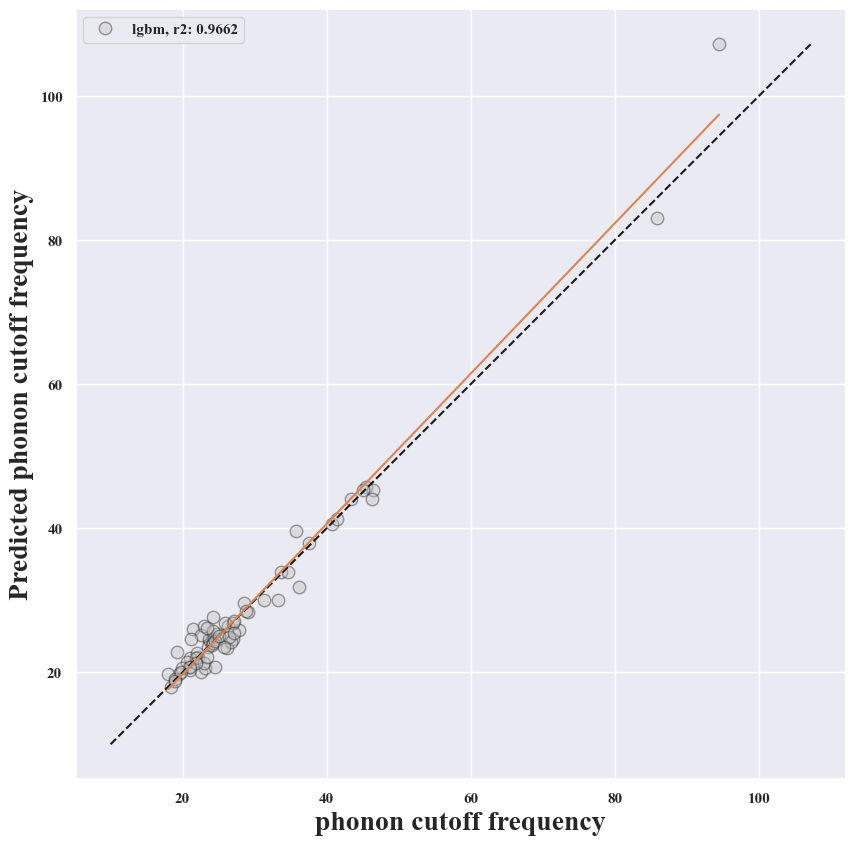

In [49]:
# predict metrics
ypred = automl.predict(x_test)
pred_result = regression_metrics(y_test,ypred)
plot=plot_pred_act(
    y_test,ypred,
    automl.best_estimator,
    reg_line=True,label='phonon cutoff frequency')

# SHAP analyse

In [14]:
# import pkgs
import shap
import lightgbm as lgb

In [18]:
# import data for shap analyse

df_train_selected = pd.read_csv("Data/phonon data/trainData_features15.csv")
feature_train = df_train_selected.iloc[:,4:]
target_train = df_train_selected["Wmax"]

# StandardScaler
feature_std = dataStandardScaler(feature_train)

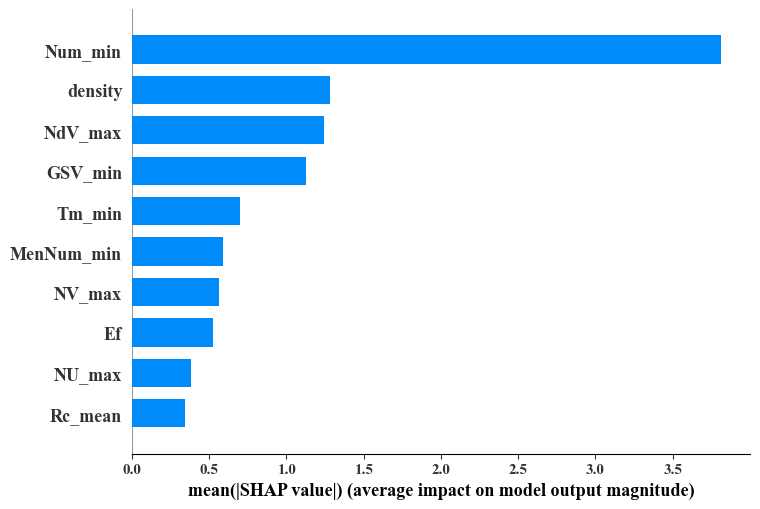

In [19]:


params = {'n_estimators': 56,
          'num_leaves': 59,
          'min_child_samples': 3,
          'learning_rate': 0.20965284786018218,
          # 'log_max_bin': 7,
          'colsample_bytree': 0.5614656111885798,
          'reg_alpha': 0.0009765625,
          'reg_lambda': 0.022677313474640613}

# init LightGBM model
model_lgb_shap = lgb.LGBMRegressor(**params)
model_lgb_shap.fit(feature_std, target_train)

# calculate shap values
shap_values = shap.Explainer(model_lgb_shap).shap_values(feature_std)
# shap feature importance 
shap.summary_plot(shap_values, feature_std, plot_type="bar", max_display=10, show=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


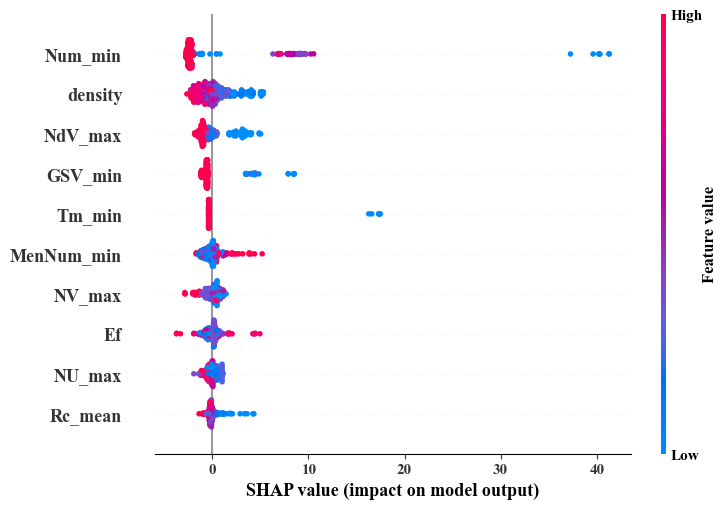

In [20]:
shap.summary_plot(shap_values, feature_std, max_display=10, plot_type="dot")
plt.show()